<a href="https://colab.research.google.com/github/1dhiman/100days-ml/blob/master/2019/tf_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download The Dataset

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz >> tmp.txt 
!rm  images/*.mat

--2019-10-07 18:46:51--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  11.8MB/s    in 67s     

2019-10-07 18:47:58 (11.3 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2019-10-07 18:48:00--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  5.59MB/s    in 3.3s    

2019-10-07 18:48:03 (5.59 MB/s)

The dataset contains around 37 category pet  with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation. For this task we only use a classification between dogs and cats so we discard the other categories. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

# Basic Introduction 

**Transfer Learning** refers to the process of using pretrained models to train a small set of classes. This is usually done when you have a small dataset with few number of images. The basic process uses fine-tuning where we use the conv layers to extract the features (i.e) these layers are frozen (not retrained). We remove the fully connected layers at the end and attach a new set of connected layers with the output as the number of classes in our dataset i.e two classes dogs and cats. The following image [reference](https://arxiv.org/abs/1704.04861) shows the process

<center>![alt text](https://cdn-images-1.medium.com/max/2000/1*f2_PnaPgA9iC5bpQaTroRw.png =500x350) </center>

**Mobilenet**  is a class of efficient models called MobileNets for mobile and embedded vision applications. MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks  [arxiv](https://arxiv.org/abs/1704.04861). This reduces the substantially the number of the parameters of the model which makes the process of retraining much faster i.e can be used for mobile devices. Here we use it because it is really fast. 

# Imports

We use tensorflow with eager execution. Hence, eager execution allows immediate evaluation of tensors without instintiating graph. 

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import cv2
import matplotlib.pyplot as plt 
import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
import tensorflow.contrib.eager as tfe

In [0]:
tf.enable_eager_execution()

# Extract Labels

So for each image path associate a label , either 0 = cat and 1 = dog.  The `xml` file contains many information like the `filename`, `bounding_box`, `size`, `label`, etc ... 

In [0]:
import xml.etree.ElementTree
import os
from random import shuffle

#read the xml file which contains the bounding boxes
xmls = os.listdir('annotations/xmls')

#store the file names and the labels
files  = []
labels = []

#shuffle the files 
shuffle(xmls)

#iterate through all the annotations
for x in xmls:
  path = f'annotations/xmls/{x}'
  
  #the root of the xml file 
  root = xml.etree.ElementTree.parse(path).getroot()
  
  obj  = root.find('object')
  
  #extract the label 
  name = obj.find('name').text
  if name == 'dog':
    lbl = 1
  else:
    lbl = 0 
  
  #extract the filename 
  filename = root.find('filename').text
  
  files.append(f'images/{filename}')
  labels.append([lbl])

#Create a Dataset

Here we use `tf.data` for manipulating the data and use them for training

In [0]:
def parse_data(filename, label):
  
  image = tf.image.decode_jpeg(tf.read_file(filename), channels = 3)
  
  image = tf.image.convert_image_dtype(image, tf.float32)
  
  image = tf.image.resize_images(image, [IMG_SIZE, IMG_SIZE])
  
  return image, label

def create_dataset(fs, ls, training = True):

  dataset = tf.data.Dataset.from_tensor_slices((fs, ls)).shuffle(len(fs) - 1)
  dataset = dataset.map(parse_data, num_parallel_calls = 4)
  dataset = dataset.batch(BATCH_SIZE)
  
  return dataset

# Data Split

We create a 10% split for the test data to be used for validation 

In [0]:
N = len(files)
M = int(0.9 * N)

#split files for images 
train_files = files[:M]
test_files  = files[M:]

#split labels
train_labels = labels[:M]
test_labels =  labels[M:]

In [7]:
print('training', len(train_files))
print('testing' , len(test_files))

training 3317
testing 369


In [0]:
IMG_SIZE = 128
NUM_CLASSES = 2 
BATCH_SIZE = 32
class_names = ['cat', 'dog']

train_dataset = create_dataset(train_files, train_labels)
test_dataset = create_dataset(test_files, test_labels)

# Visualization 

In [0]:
def plot_annot(x, y):
  #convert to numpy 
  img   = x.numpy() 
  annot = y.numpy()
  
  #extract the label and its name 
  print(class_names[y])
  
  plt.axis('off')
  plt.imshow(img)
  plt.show()

dog


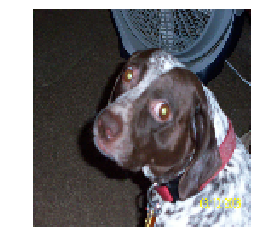

In [10]:
for x, y in train_dataset:
  plot_annot(x[0], y[0])
  break

# Create a model 

In [11]:
#download and load the pretrained model
mobilenet = tf.keras.applications.MobileNetV2(input_shape = (128, 128, 3), weights ='imagenet', include_top = False)

#freeze all the layers as a fixed feature extractor
for layer in mobilenet.layers:
  layer.trainable = False
  
flatten = GlobalAveragePooling2D()(mobilenet.output)

#first branch for classification
branch1 = Dense(256, activation = 'relu')(flatten)
out1 = Dense(NUM_CLASSES)(branch1)

#create a model with one input and two outputs 
model = tf.keras.models.Model(inputs = mobilenet.input, outputs = out1)

9412608/9406464 [==============================] - 2s 0us/step


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

Here, we evaluate the loss and the gradient of the loss. The `grad` function evaluates the gradient of the mode with respect to the parameters. We use `sparse_softmax_cross_entropy` which evaluates the usual coss entropy but on raw labels i.e not one hot encoded. 

In [0]:
def loss(pred, y):
  prediction_error = tf.losses.sparse_softmax_cross_entropy(y, logits = pred)  
  return prediction_error           

Create the optimizer and the gradient function 

In [0]:
def grad(model, x, y):
  #record the gradient
  with tf.GradientTape() as tape:
    pred = model(x)
    value = loss(pred, y)
  #return the gradient of the loss function with respect to the model trainable variables 
  return tape.gradient(value, model.trainable_variables)

optimizer = tf.train.AdamOptimizer()

Here we need to evaluate the metrics of the classification. We use the basic accuracy metric. 

In [0]:
def acc(pred, y):
  #get the labels of the predicted values 
  yhat = tf.argmax(pred, 1).numpy()
  
  #get the labels of the true values
  y    = y[:,0].numpy()
  return np.sum(y == yhat)/len(y)

Record the history of loss and accuracy of training and validation

In [0]:
epochs = 3

#initialize the history to record the metrics 
train_loss_history = tfe.metrics.Mean('train_loss')
train_acc_history  = tfe.metrics.Mean('train_acc')

test_loss_history = tfe.metrics.Mean('test_loss')
test_acc_history  = tfe.metrics.Mean('test_acc')

# Training

In [17]:
for i in range(0, epochs):
  
  for x, y in train_dataset:
    pred = model(x)
    grads = grad(model, x, y)

    #update the trainable paramters of the model 
    optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step = tf.train.get_or_create_global_step())

    #record the metrics of the current batch 
    loss_value = loss(pred, y)
    acc_value  = acc(pred,y)
    
    #calcualte the metrics of the current batch
    train_loss_history(loss_value)
    train_acc_history(acc_value)
  
  #loop over the test dataset 
  for x, y in test_dataset:
    pred = model(x)
    
    #calcualte the metrics of the current batch 
    loss_value = loss(pred, y)
    acc_value  = acc(pred,y)
    
    #record the values of the metrics 
    test_loss_history(loss_value)
    test_acc_history(acc_value)
    
  #print out the results 
  print("epoch: [{0:d}/{1:d}], Train: [loss: {2:0.4f}, acc: {3:0.2f}], Test: [loss: {4:0.4f}, acc: {5:0.2f}]".
       format(i, epochs, train_loss_history.result(),  train_acc_history.result(),
             test_loss_history.result(),  test_acc_history.result()))
  
  #clear the history after each epoch 
  train_acc_history.init_variables()
  train_loss_history.init_variables()
  
  test_acc_history.init_variables()
  test_loss_history.init_variables()


epoch: [0/3], Train: [loss: 0.1328, acc: 0.95], Test: [loss: 0.1658, acc: 0.95]
epoch: [1/3], Train: [loss: 0.0348, acc: 0.99], Test: [loss: 0.1022, acc: 0.97]
epoch: [2/3], Train: [loss: 0.0197, acc: 0.99], Test: [loss: 0.1066, acc: 0.97]


# Visualization 

In [0]:
#get the conficence value and the higest predicted value 
def get_confidence(logits):
  exp = tf.exp(logits)
  softmax = exp/np.sum(exp)
  
  max_index =  tf.argmax(logits)
  confidence=  softmax[max_index]
  return max_index.numpy() , confidence.numpy()

#visualize the predicted bounding box
def plot_annot(img_id):
  
  raw = cv2.imread(img_id)[:,:,::-1]
  
  h, w = (1024, 1024)
  
  #load and preprocess
  img = cv2.resize(raw, (IMG_SIZE, IMG_SIZE)).astype('float32')
  img = np.expand_dims(img, 0)/255. 
  
  #predict the model 
  pred = model(img)
  
  #extract the label and confidence
  label, confidence = get_confidence(pred[0])
  
  if label:
    color = (0, 0, 255)
  else:
    color = (0, 255, 0)
    
  weight = 2
  
  #write the class name on the image 
  font = cv2.FONT_HERSHEY_SIMPLEX
  text = f'{class_names[label]}: {int(confidence * 100)} %'
  text_len = len(text)
  raw = cv2.resize(raw, (w, h))
  raw = cv2.rectangle(raw, (10, 70), (20 +text_len * 9 * weight,0), color, cv2.FILLED)
  raw = cv2.putText(raw, f'{text}',(15, 50), font, 1,(255,255,255), weight , cv2.LINE_AA)
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(raw)

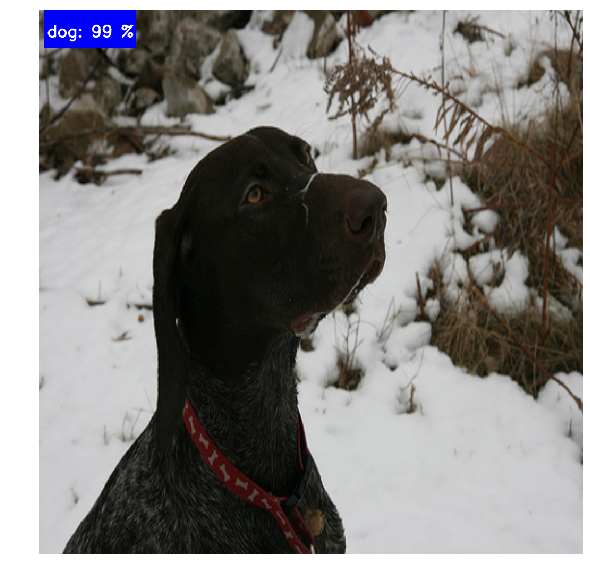

In [19]:
img_id = np.random.choice(test_files)

plot_annot(img_id)

# Test on New Images

In [20]:
!wget https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg -O cat.jpg 

--2019-10-07 18:50:20--  https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.17.209.102, 104.17.208.102, 2606:4700::6811:d066, ...
Connecting to images.pexels.com (images.pexels.com)|104.17.209.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 945751 (924K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 923.58K  --.-KB/s    in 0.01s   

2019-10-07 18:50:21 (61.0 MB/s) - ‘cat.jpg’ saved [945751/945751]



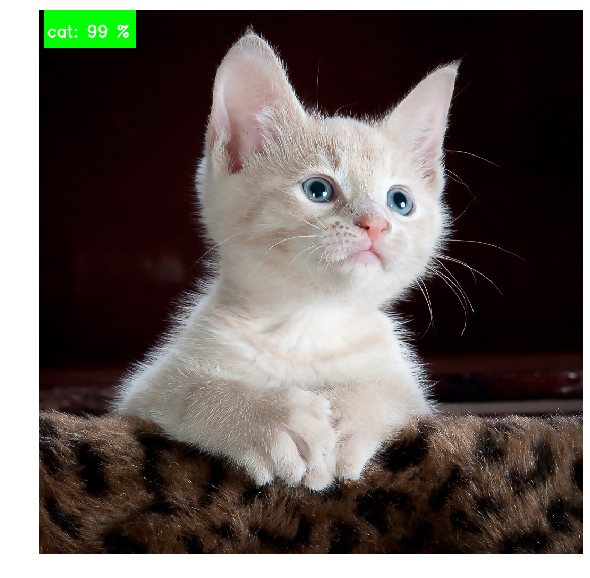

In [21]:
plot_annot('cat.jpg')

In [22]:
!wget https://pbs.twimg.com/profile_images/941322358245154816/tF4dPHrS_400x400.jpg -O dog.jpg

--2019-10-07 18:50:27--  https://pbs.twimg.com/profile_images/941322358245154816/tF4dPHrS_400x400.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.237.96, 2606:2800:248:1707:10d3:19d0:1ba2:1a23
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.237.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23870 (23K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  23.31K  --.-KB/s    in 0s      

2019-10-07 18:50:27 (178 MB/s) - ‘dog.jpg’ saved [23870/23870]



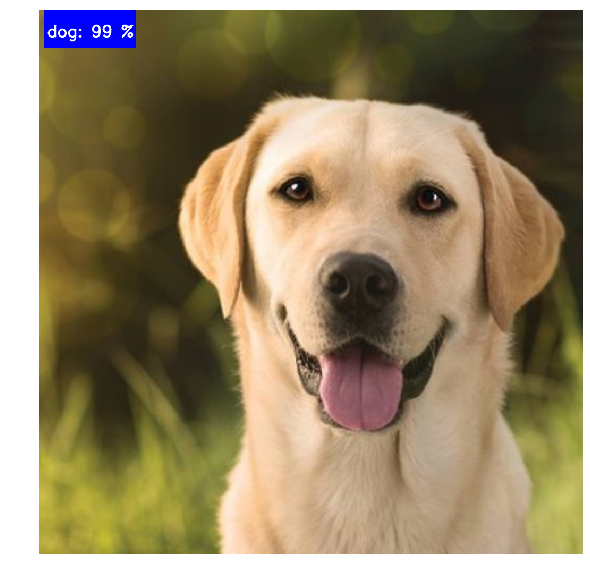

In [23]:
plot_annot('dog.jpg')